In [1]:
import pandas as pd
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
import pandas as pd
import rdchiral
import itertools
import pickle
import sys
from tqdm import tqdm 
from rdchiral.main import rdchiralRun, rdchiralRunText, rdchiralReaction, rdchiralReactants
import cobra
from itertools import chain, combinations
import sys
from ast import literal_eval
import multiprocessing
from functools import partial
sys.path.append('../retrosynthesis/')

from common import *

In [2]:
mnxreac_smile_atom_mapping_rules_file_path = '../../Results/rules/MNXreaction_smiles_atommap_rules_filter.csv'
rxndb_total_info_to_model_path = '../../Results/not_lipid/top50_0.3_re/rxndb_total_info_to_model_top50_0.3.csv'
yeast_met_file = '../../Results/not_lipid/yeast_met_not_lipid.pickle'
yeast870_path = '../../Data/model/yeast-GEM.yml'
figs8_data_path = '../../Results/source_data/figs8.csv'
figs8_path = '../../Results/Figures/figs8.pdf'

In [3]:
yeast_total_smiles_extend = load_pickle(yeast_met_file)
print(len(yeast_total_smiles_extend))

3680


In [4]:
rules = pd.read_csv(mnxreac_smile_atom_mapping_rules_file_path)
rules = rules[['MNX_ID','product_smiles','ProductSMARTs','RetroRules']]
print(rules.shape)
rules = rules[~rules['ProductSMARTs'].isna()]
print(rules.shape)
rules.head(1)

(21921, 4)
(21921, 4)


,MNX_ID,product_smiles,ProductSMARTs,RetroRules
0,MNXR100024,[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...


In [5]:
mets_total_smiles = yeast_total_smiles_extend

In [6]:
def smiles_similarity(target_smiles, product_smiles):
    res = 0
    smiles_list = product_smiles.split('.')
    for smiles in smiles_list:
        if 'c' in smiles or 'C' in smiles:  # only match substrates with Carbon
            smile_fps = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles))
            target_smiles_fps = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(target_smiles))
            tmp_scores = DataStructs.FingerprintSimilarity(smile_fps, target_smiles_fps)
            if tmp_scores>0.3:
                res = 1
        else:pass

    return(res)

In [7]:
from rdkit import Chem

def match_smarts(target_smiles, ProductSMARTs):
    res = 0  # No match
    smarts_list = ProductSMARTs.split('.')
    
    # Only match substrates with Carbon
    if 'c' in target_smiles or 'C' in target_smiles:
        target_smiles = Chem.MolFromSmiles(target_smiles)
        
        for smarts in smarts_list:
            if target_smiles.HasSubstructMatch(Chem.MolFromSmarts(smarts)):
                res = 1  # Match found
    else:
        pass  # No carbon in target_smiles
    
    return res

In [8]:
rules

,MNX_ID,product_smiles,ProductSMARTs,RetroRules
0,MNXR100024,[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...
1,MNXR100024_reverse,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H],[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:5])=[O;D1;H0:...,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:5])=[O;D1;H0:...
2,MNXR100030,[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...
3,MNXR100030_reverse,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H],[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:5])=[O;D1;H0:...,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:5])=[O;D1;H0:...
4,MNXR100060,O=CCO.[H]O[H],[C:1]-[CH;D2;+0:2]=[O;D1;H0:4].[OH2;D0;+0:3],[C:1]-[CH;D2;+0:2]=[O;D1;H0:4].[OH2;D0;+0:3]>>...
...,...,...,...,...
21916,MNXR99896_reverse,[NH3+][C@@H](CCC=O)C(=O)[O-].O=P([O-])([O-])O,[#15:1]-[OH;D1;+0:2].[C:4]-[CH;D2;+0:3]=[O;D1;...,[#15:1]-[OH;D1;+0:2].[C:4]-[CH;D2;+0:3]=[O;D1;...
21917,MNXR99898_reverse,[NH3+][C@@H](CCC=O)C(=O)[O-].O=P([O-])([O-])O,[#15:1]-[OH;D1;+0:2].[C:4]-[CH;D2;+0:3]=[O;D1;...,[#15:1]-[OH;D1;+0:2].[C:4]-[CH;D2;+0:3]=[O;D1;...
21918,MNXR99920_reverse,O=C([O-])/C=C(\C=C(\O)C(=O)[O-])C(=O)[O-],[O-;H0;D1:13]-[C;H0;D3;+0:6](=[O;H0;D1;+0:7])-...,[O-;H0;D1:13]-[C;H0;D3;+0:6](=[O;H0;D1;+0:7])-...
21919,MNXR99957,O=C([O-])[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO,[C:1]-[C@H;D3;+0:2](-[OH;D1;+0:8])-[C@@H;D3;+0...,[C:1]-[C@H;D3;+0:2](-[OH;D1;+0:8])-[C@@H;D3;+0...


In [9]:
def process_smiles(smiles):
    match_num = 0
    match_rule_lst = []
    for index,row in rules.iterrows():
        if match_smarts(smiles, row['ProductSMARTs']) and smiles_similarity(smiles, row['product_smiles']):
            match_num+=1
            match_rule_lst.append(row['MNX_ID'])
    return(smiles, match_num,match_rule_lst)

smiles_pool = multiprocessing.Pool(processes=20)
smiles_match_rules = {'smiles':[],'match_rules':[],'match_rule_lst':[]}

for result in tqdm(smiles_pool.imap_unordered(process_smiles, mets_total_smiles), total=len(mets_total_smiles)):
    smiles_match_rules['smiles'].append(result[0])
    smiles_match_rules['match_rules'].append(result[1])
    smiles_match_rules['match_rule_lst'].append(result[2])

100%|██████████| 3680/3680 [42:13<00:00,  1.45it/s]  


In [10]:
smiles_match_rules_df = pd.DataFrame(smiles_match_rules)
smiles_match_rules_df

,smiles,match_rules,match_rule_lst
0,CC(C)C(C)C(C)C,3,"[MNXR114742, MNXR121040, MNXR121056_reverse]"
1,CCc1cc(C)ccc1C,55,"[MNXR108253_reverse, MNXR109266_reverse, MNXR1..."
2,CCO,293,"[MNXR100328, MNXR100348, MNXR100413, MNXR10310..."
3,CC1=C(C)CC(C)(C=O)CC1,302,"[MNXR100143_reverse, MNXR102250_reverse, MNXR1..."
4,CN(CC(=O)O)C(N)=NP(=O)(O)O,872,"[MNXR100328, MNXR100348, MNXR100348_reverse, M..."
...,...,...,...
3675,CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H]...,3587,"[MNXR100113, MNXR100114_reverse, MNXR100129, M..."
3676,CCCCCCC=CCCCCCCCCCC(=O)OCC(COP(=O)(O)OP(=O)(O)...,1673,"[MNXR100129, MNXR100328, MNXR100348, MNXR10034..."
3677,CCCCCCCCCCCCCCCCCCCCCCC(O)C(=O)NC(COP(=O)(O)OC...,1804,"[MNXR100114_reverse, MNXR100129, MNXR100328, M..."
3678,Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)...,1566,"[MNXR100129, MNXR100328, MNXR100348, MNXR10034..."


# merge smiles_match_rules_df based on idendical smiles

In [11]:
len(smiles_match_rules_df['match_rule_lst'].to_list()[0])

3

In [12]:
smiles_match_rules_dict = {}
for index, row in tqdm(smiles_match_rules_df.iterrows(), total=len(smiles_match_rules_df)):
    if smiles_has_carbon(row['smiles']):
        # Check if any SMILES in the dictionary matches the current row's SMILES
        matched_key = None
        for smiles in smiles_match_rules_dict.keys():
            if compare_smiles_inchikey(smiles, row['smiles']):
                matched_key = smiles
                break
        
        if matched_key:
            # Append to the existing match_rule_lst if a match is found
            smiles_match_rules_dict[matched_key] += row['match_rule_lst']
        else:
            # Create a new entry in the dictionary if no match is found
            smiles_match_rules_dict[row['smiles']] = row['match_rule_lst']


100%|██████████| 3680/3680 [39:21<00:00,  1.56it/s]


In [13]:
smiles_match_rules_dict = {k:list(set(v)) for k,v in smiles_match_rules_dict.items()}

In [14]:
smiles_match_rules_dict = {k:len(v) for k,v in smiles_match_rules_dict.items()}

In [15]:
smiles_match_rules_dict

{'CC(C)C(C)C(C)C': 3,
 'CCc1cc(C)ccc1C': 55,
 'CCO': 293,
 'CC1=C(C)CC(C)(C=O)CC1': 302,
 'CN(CC(=O)O)C(N)=NP(=O)(O)O': 1922,
 'CCCCCCCCC[C@@H](O)CC(=O)O': 1834,
 '[NH3+][C@@H](CO)C(=O)[O-]': 1904,
 'O=C(CO)C(O)C(O)C(O)CO': 1690,
 'OC[C@@H]1O[C@@](O)(CO)[C@H](O)[C@H]1O': 1823,
 'O=C([O-])CC[C@H](C(=O)[O-])[C@@H](O)C(=O)[O-]': 2140,
 'C[C@H]([NH3+])C(=O)N[C@H](C(=O)[O-])[C@@H](C)O': 1954,
 'N[C@H]1C(O)O[C@@H](CO)[C@@H](O)[C@@H]1O': 2338,
 'CC(C)=CCC/C(C)=C/CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\COP(=O)([O-])OP(=O)([O-])[O-]': 808,
 'Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1': 1496,
 'CCCCCCCCC=CCCCCCCCC(=O)OCC(COP(=O)(O)OCCN(C)C)OC(=O)CCCCCCCC=CCCCCCCCC': 1199,
 'O=C(CO)[C@H](O)[C@H](O)COP(=O)([O-])[O-]': 2737,
 'OC[C@H]1O[C@H](O[C@]2(CO)O[C@H](CO)[C@@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@@H]1O': 1858,
 'O=c1[nH]cnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O': 2285,
 'Oc1cc(O)c2c(c1)O[C@@H](c1ccc(O)c(O)c1)[C@@H](O)C2': 1957,
 'O=C(COP(=O)(O)O)[C@@H](O)[C@H](O)[C@@H](O)CO': 2691,
 'OCCCO': 67

In [16]:
# result = {'smiles':[],
#           'match_rules':[],
#           'reaction_num':[]}

# rxndb_total_info_to_model = pd.read_csv(rxndb_total_info_to_model_path)

# for smiles1,match_rules in tqdm(smiles_match_rules_dict.items(),total=len(smiles_match_rules_dict)):
#     reaction_num = 0 
#     for index,row in rxndb_total_info_to_model.iterrows():
#         smiles_lst = row['rxn_smiles_final'].replace('>>','.').split('.')
#         if any(compare_smiles_inchikey(smiles1,smiles2) for smiles2 in smiles_lst):
#             reaction_num+=1
#     result['smiles'].append(smiles1)       
#     result['match_rules'].append(match_rules)        
#     result['reaction_num'].append(reaction_num)        

In [17]:


# Load data
rxndb_total_info_to_model = pd.read_csv(rxndb_total_info_to_model_path)

# Define the worker function
def match_smiles(smiles1_match_rules, rxndb_total_info_to_model):
    smiles1, match_rules = smiles1_match_rules
    reaction_num = 0 
    for index, row in rxndb_total_info_to_model.iterrows():
        smiles_lst = row['rxn_smiles_final'].replace('>>', '.').split('.')
        if any(compare_smiles_inchikey(smiles1, smiles2) for smiles2 in smiles_lst):
            reaction_num += 1
    return smiles1, match_rules, reaction_num

# Define the result dictionary
result = {'smiles': [], 'match_rules': [], 'reaction_num': []}

# Extract the task list for parallel processing
tasks = [(smiles1, match_rules) for smiles1, match_rules in smiles_match_rules_dict.items()]

# Set the number of processes
num_processes = 20
pool = multiprocessing.Pool(num_processes)

# Use partial to pass rxndb_total_info_to_model to match_smiles
match_smiles_partial = partial(match_smiles, rxndb_total_info_to_model=rxndb_total_info_to_model)

# Parallel processing
for smiles1, match_rules, reaction_num in tqdm(pool.imap(match_smiles_partial, tasks), total=len(tasks)):
    result['smiles'].append(smiles1)
    result['match_rules'].append(match_rules)
    result['reaction_num'].append(reaction_num)

# Close the process pool
pool.close()
pool.join()

100%|██████████| 1457/1457 [46:30<00:00,  1.92s/it] 


In [18]:
result_df = pd.DataFrame(result)

In [19]:
# Calculate the correlation
correlation = result_df['match_rules'].corr(result_df['reaction_num'])
print(f"Correlation between match_rules and reaction_num: {correlation}")

Correlation between match_rules and reaction_num: 0.1824620341770432


In [20]:
# Assuming you want to sort by the 'score' column in descending order

result_df_sorted = result_df.sort_values(by='reaction_num', ascending=False)

result_df_sorted[~result_df_sorted['smiles'].str.contains('\.')]
result_df_sorted = result_df_sorted[result_df_sorted['smiles']!='O=C=O']
result_df_sorted = result_df_sorted[result_df_sorted['smiles']!='NC(=O)c1ccc[n+]([C@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1']
result_df_sorted = result_df_sorted[result_df_sorted['smiles']!='NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)c1']
result_df_sorted = result_df_sorted[result_df_sorted['smiles']!='NC(=O)C1=CN([C@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1']
result_df_sorted = result_df_sorted[result_df_sorted['smiles']!='NC(=O)C1=CN([C@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1']
result_df_sorted = result_df_sorted[result_df_sorted['smiles']!='C=O']
result_df_sorted = result_df_sorted[result_df_sorted['smiles']!='CO']
result_df_sorted = result_df_sorted[result_df_sorted['smiles']!='CS']

# Calculate the correlation
correlation = result_df_sorted['match_rules'].corr(result_df_sorted['reaction_num'])
print(f"Correlation between match_rules and reaction_num: {correlation}")

result_df_sorted

Correlation between match_rules and reaction_num: 0.19410011184062828


,smiles,match_rules,reaction_num
903,NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)(O)OCC...,2170,677
1061,NC(=O)c1ccc[n+]([C@H]2O[C@H](COP(=O)([O-])OP(=...,2392,645
247,NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...,2070,633
136,Nc1ncnc2c1ncn2[C@H]1O[C@H](COP(=O)([O-])OP(=O)...,2269,563
665,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H]...,2224,408
...,...,...,...
822,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,2466,0
825,CCc1nc(C)oc1C,10,0
826,CCCCCCCC(=O)CCCCCCC,355,0
827,CC(=O)c1nccs1,37,0


In [21]:
# Define a function to calculate the number of carbon atoms

def count_carbon_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return sum(atom.GetAtomicNum() == 6 for atom in mol.GetAtoms())

# Apply the apply method to apply a function to a SMILES column in a DataFrame
result_df_sorted['carbon_count'] = result_df_sorted['smiles'].apply(count_carbon_atoms)
result_df_sorted

,smiles,match_rules,reaction_num,carbon_count
903,NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)(O)OCC...,2170,677,21
1061,NC(=O)c1ccc[n+]([C@H]2O[C@H](COP(=O)([O-])OP(=...,2392,645,21
247,NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...,2070,633,21
136,Nc1ncnc2c1ncn2[C@H]1O[C@H](COP(=O)([O-])OP(=O)...,2269,563,10
665,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H]...,2224,408,10
...,...,...,...,...
822,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,2466,0,51
825,CCc1nc(C)oc1C,10,0,7
826,CCCCCCCC(=O)CCCCCCC,355,0,15
827,CC(=O)c1nccs1,37,0,5


In [22]:
result_df_sorted.to_csv(figs8_data_path,index=None)

In [26]:
from scipy.stats import pearsonr
# tmp1 = result_df_sorted[(result_df_sorted['Molecular_Weight']<200)&(result_df_sorted['Molecular_Weight']>50)]
# tmp2 = result_df_sorted[(result_df_sorted['Molecular_Weight']>200)|(result_df_sorted['Molecular_Weight']<50)]
tmp1 = result_df_sorted[(result_df_sorted['carbon_count']<9)&(result_df_sorted['carbon_count']>3)]
tmp2 = result_df_sorted[(result_df_sorted['carbon_count']>9)|(result_df_sorted['carbon_count']<3)]
# 计算相关系数和 p 值
correlation, p_value = pearsonr(tmp1['match_rules'], tmp1['reaction_num'])

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# 计算相关系数和 p 值
correlation, p_value = pearsonr(tmp2['match_rules'], tmp2['reaction_num'])

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Correlation coefficient: 0.4049008117852858
P-value: 4.6896787439534494e-24
Correlation coefficient: 0.09756832281783158
P-value: 0.00948519931564806


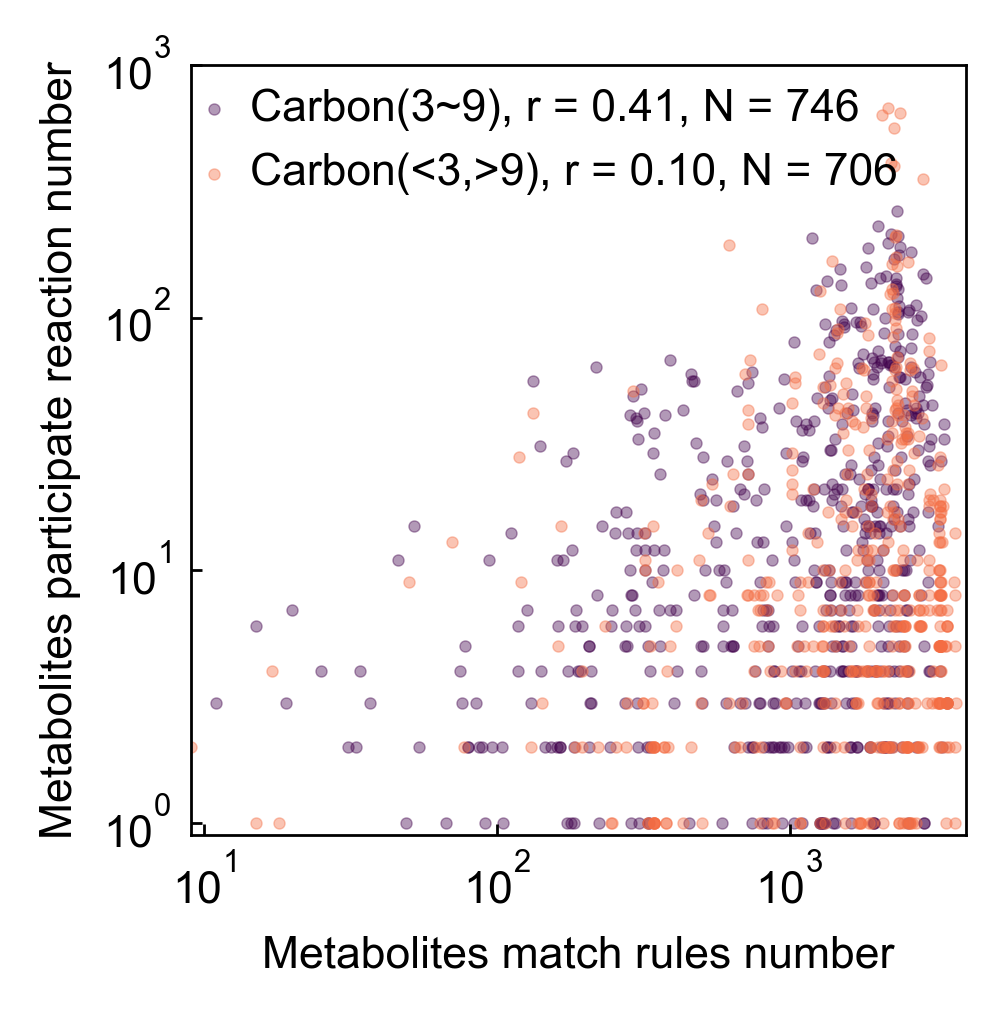

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Setting General Parameters
plt.figure(figsize=(2.5, 2.5), dpi=400)
plt.rcParams.update({'font.size': 8})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Setting Axis Styles
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)

# Adjusting the size of scatter points (s parameter) and using normalized 'score'
plt.scatter(tmp1['match_rules'], tmp1['reaction_num'], 
            s=4,  # Size of the points
            c='#40004b',  # Color of the points
            edgecolor='#40004b',  # Border color of the points
            linewidth=0.25,  # Border width of the points
            alpha=0.4,  # Transparency of the points
            label='Carbon(3~9), r = 0.41, N = 746'  # Label
           )

plt.scatter(tmp2['match_rules'], tmp2['reaction_num'], 
            s=4,  # Size of the points
            c='#f46d43',  # Color of the points
            edgecolor='#f46d43',  # Border color of the points
            linewidth=0.25,  # Border width of the points
            alpha=0.4,  # Transparency of the points
            label='Carbon(<3,>9), r = 0.10, N = 706'  # Label
           )

# Setting X-axis Labels
plt.xlabel('Metabolites match rules number', fontsize=8)
plt.ylabel('Metabolites participate reaction number', fontsize=8)

plt.xlim(9, 4000)
plt.ylim(0.9, 1000)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.minorticks_off()  # Hide minor ticks

plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)

# Adding Legend
plt.legend(frameon=False, fontsize=8, loc='center left', bbox_to_anchor=(-0.05, 0.9), ncol=1, labelspacing=0.5, handletextpad=0.3, handlelength=1)

# Save the figure to a file
plt.savefig(figs8_path, dpi=400, bbox_inches='tight')
plt.show()